## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

import os
import tqdm



## Analyze trajectories

In [101]:
plt.figure(figsize=(15,8))

for pot in ['no_potential','dmasif_potential']:
    steps=[]
    plddts=[]
    titles=[]
    it=0
    step=[]
    plddt=[]
    with open(f'logs/design_{pot.replace('_potential','')}.log','r') as f:
        for line in f:
            if line.split(' ')[-1]==pot:
                titles.append(line.split(' ')[0])
                steps.append([])
                plddts.append([])
            elif line[:12]=='    TIMESTEP':
                step.append(int(line[14:16]))
                plddt.append(float(line[42:48]))
                if step[-1]==1:
                    steps[-1].append(step)
                    plddts[-1].append(plddt)
                    step=[]
                    plddt=[]
    for i, title in enumerate(titles):
        plt.title(title)
        plt.subplot(2,3,i+1)
        for j in range(len(steps[i])):
            plt.plot(steps[i][j], plddts[i][j], alpha=[0.1,0.2][pot!='no_potential'], 
                     linewidth=0.5, color=['blue','red'][pot!='no_potential'], label=(pot if j==0 else None))
        plt.xlim((25,0))
plt.legend()
plt.plot()

SyntaxError: invalid syntax (1984519714.py, line 10)

## Analyze secondary structures

In [81]:
arr=[]
for potential in ['no_potential','dmasif_potential', 'dmasif_potential_t5']:
    for file in os.listdir(f'outputs/dssp_statistics/{potential}'):
        d={'H':0,'S':0,'T':0,'G':0,'B':0,'I':0,'E':0,' ':0}
        with open(f'outputs/dssp_statistics/{potential}/{file}') as f:
            for s in f:
                if s[-1]=='.':
                    continue
                if s[11]!='B':
                    continue
                d[s[16]]+=1
        arr.append([file.split('.')[0],'_'.join(file.split('_')[:-1]),potential]+[d.get(x,0) for x in 'HSTGBIE '])
sec_df=pd.DataFrame(columns=['name','protein','potential','alpha\nhelix','bend',
                             'turn','3-10\nhelix','beta\nbridge','pi\nhelix','beta\nsheet','other'], 
                    data=arr)
sec_df

,name,protein,potential,alpha\nhelix,bend,turn,3-10\nhelix,beta\nbridge,pi\nhelix,beta\nsheet,other
0,il_7ra_000930,il_7ra,no_potential,29,2,2,3,0,0,23,12
1,insr_000719,insr,no_potential,83,5,1,0,0,0,0,9
2,ih_000648,ih,no_potential,68,0,6,0,0,0,0,11
3,ih_000272,ih,no_potential,79,1,6,0,0,0,0,10
4,insr_000323,insr,no_potential,38,2,6,0,1,0,19,22
...,...,...,...,...,...,...,...,...,...,...,...
7495,il_7ra_000132,il_7ra,dmasif_potential_t5,16,3,6,0,0,0,36,13
7496,pd_l1_000201,pd_l1,dmasif_potential_t5,72,2,2,0,0,0,0,14
7497,trka_000189,trka,dmasif_potential_t5,55,2,2,4,0,0,0,7
7498,ih_000236,ih,dmasif_potential_t5,67,0,4,0,0,0,6,14


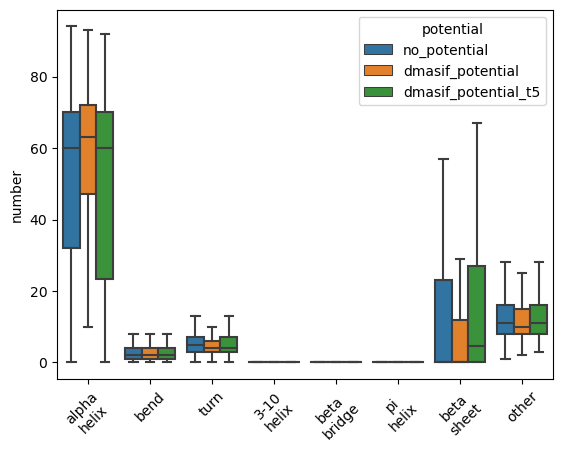

In [82]:

sns.boxplot(data=pd.melt(sec_df, id_vars=['name', 'protein', 'potential']), 
            x='variable', y='value', hue='potential', showfliers=False)
plt.xticks(rotation=45) 
plt.xlabel('')
plt.ylabel('number') 
plt.show()



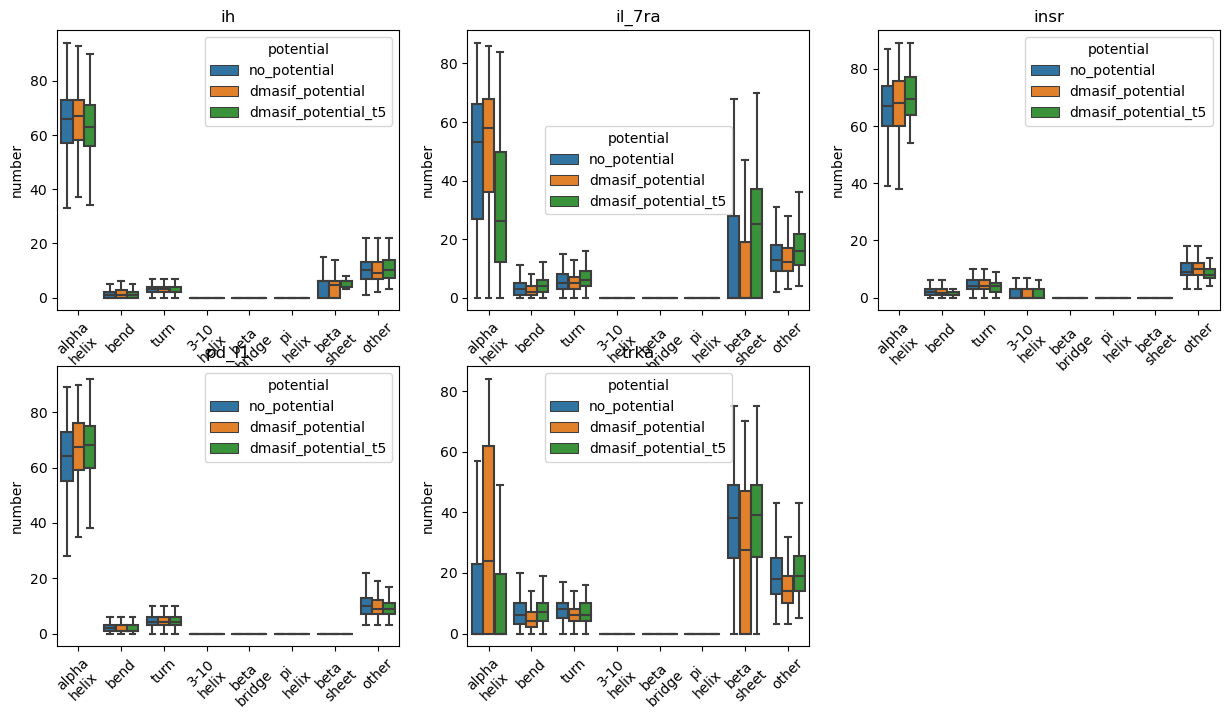

In [83]:
plt.figure(figsize=(15,8))
proteins=sec_df.protein.unique()
proteins.sort()
for i, prot in enumerate(proteins):
    plt.subplot(2,3,i+1)
    plt.title(prot)
    sns.boxplot(data=pd.melt(sec_df[sec_df.protein==prot], id_vars=['name', 'protein', 'potential']), 
            x='variable', y='value', hue='potential', showfliers=False)
    plt.xlabel('')
    plt.ylabel('number') 
    plt.xticks(rotation=45) 

## Analyze aminoacids

### Distiribution of all aminoacids

In [86]:
import warnings
from Bio import SeqIO


warnings.simplefilter("ignore")
arr=[]
for potential in ['no_potential','dmasif_potential', 'dmasif_potential_t5']:
    for file in tqdm.tqdm(os.listdir(f'outputs/proteingenerator_outputs/{potential}')):
        if file[-3:]!='pdb':
            continue
        for record in SeqIO.parse(f'outputs/proteingenerator_outputs/{potential}/{file}', "pdb-atom"):
            if record.id[-1]=='B':
                arr.append([file[:-4], record.seq, potential])

  
seq_df=pd.DataFrame(columns=['name','seq','potential'], data=arr)
seq_df['protein']=seq_df.name.apply(lambda x: '_'.join(x.split('_')[:-1]))
seq_df['seq']=seq_df.seq.apply(lambda x: x.split(':')[0])

seq_df

100%|██████████| 2500/2500 [01:22<00:00, 30.47it/s]


,name,seq,potential,protein
0,pd_l1_000499,"(N, T, K, K, S, K, I, F, E, E, I, R, N, I, K, ...",no_potential,pd_l1
1,trka_000399,"(S, P, T, A, R, I, T, V, R, N, A, N, G, N, V, ...",no_potential,trka
2,insr_000017,"(N, V, E, S, L, K, S, E, I, K, D, L, F, D, L, ...",no_potential,insr
3,insr_000476,"(N, D, L, L, R, L, K, E, E, L, D, K, L, V, S, ...",no_potential,insr
4,insr_000804,"(G, I, P, D, A, D, I, E, R, L, R, E, F, I, E, ...",no_potential,insr
...,...,...,...,...
7495,trka_000026,"(G, S, P, N, V, N, V, S, G, S, A, S, V, N, A, ...",dmasif_potential_t5,trka
7496,pd_l1_000173,"(D, V, E, R, Q, R, L, E, A, L, A, S, I, L, Q, ...",dmasif_potential_t5,pd_l1
7497,insr_000136,"(S, K, A, D, E, E, L, R, K, L, K, E, L, I, Q, ...",dmasif_potential_t5,insr
7498,ih_000076,"(G, N, G, K, I, R, I, V, Y, G, P, R, G, K, F, ...",dmasif_potential_t5,ih


In [87]:
alphabet='GAVLIPFYHRKDNEQSTCMW'
arr=seq_df[['potential', 'protein']]
arr['length']=seq_df.seq.apply(lambda x: len(x))
for a in alphabet:
    arr[a]=seq_df.seq.apply(lambda x: x.count(a))/arr.length
arr

,potential,protein,length,G,A,V,L,I,P,F,...,K,D,N,E,Q,S,T,C,M,W
0,no_potential,pd_l1,79,0.037975,0.012658,0.012658,0.075949,0.113924,0.037975,0.075949,...,0.151899,0.088608,0.025316,0.139241,0.037975,0.012658,0.050633,0.012658,0.0,0.0
1,no_potential,trka,94,0.138298,0.148936,0.138298,0.053191,0.031915,0.010638,0.042553,...,0.010638,0.000000,0.074468,0.042553,0.000000,0.117021,0.159574,0.000000,0.0,0.0
2,no_potential,insr,84,0.035714,0.023810,0.047619,0.142857,0.071429,0.023810,0.023810,...,0.130952,0.071429,0.011905,0.202381,0.000000,0.047619,0.011905,0.000000,0.0,0.0
3,no_potential,insr,71,0.028169,0.000000,0.042254,0.197183,0.070423,0.028169,0.000000,...,0.169014,0.056338,0.014085,0.183099,0.000000,0.056338,0.014085,0.000000,0.0,0.0
4,no_potential,insr,74,0.027027,0.013514,0.013514,0.148649,0.135135,0.027027,0.027027,...,0.094595,0.067568,0.013514,0.216216,0.000000,0.027027,0.013514,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,dmasif_potential_t5,trka,91,0.230769,0.142857,0.120879,0.021978,0.000000,0.021978,0.021978,...,0.000000,0.000000,0.076923,0.000000,0.000000,0.230769,0.098901,0.021978,0.0,0.0
7496,dmasif_potential_t5,pd_l1,71,0.056338,0.042254,0.056338,0.140845,0.070423,0.028169,0.028169,...,0.098592,0.070423,0.000000,0.183099,0.028169,0.028169,0.014085,0.000000,0.0,0.0
7497,dmasif_potential_t5,insr,98,0.030612,0.010204,0.010204,0.153061,0.112245,0.010204,0.030612,...,0.173469,0.040816,0.020408,0.244898,0.010204,0.040816,0.020408,0.000000,0.0,0.0
7498,dmasif_potential_t5,ih,98,0.061224,0.040816,0.010204,0.102041,0.122449,0.010204,0.051020,...,0.244898,0.040816,0.040816,0.193878,0.000000,0.010204,0.010204,0.000000,0.0,0.0


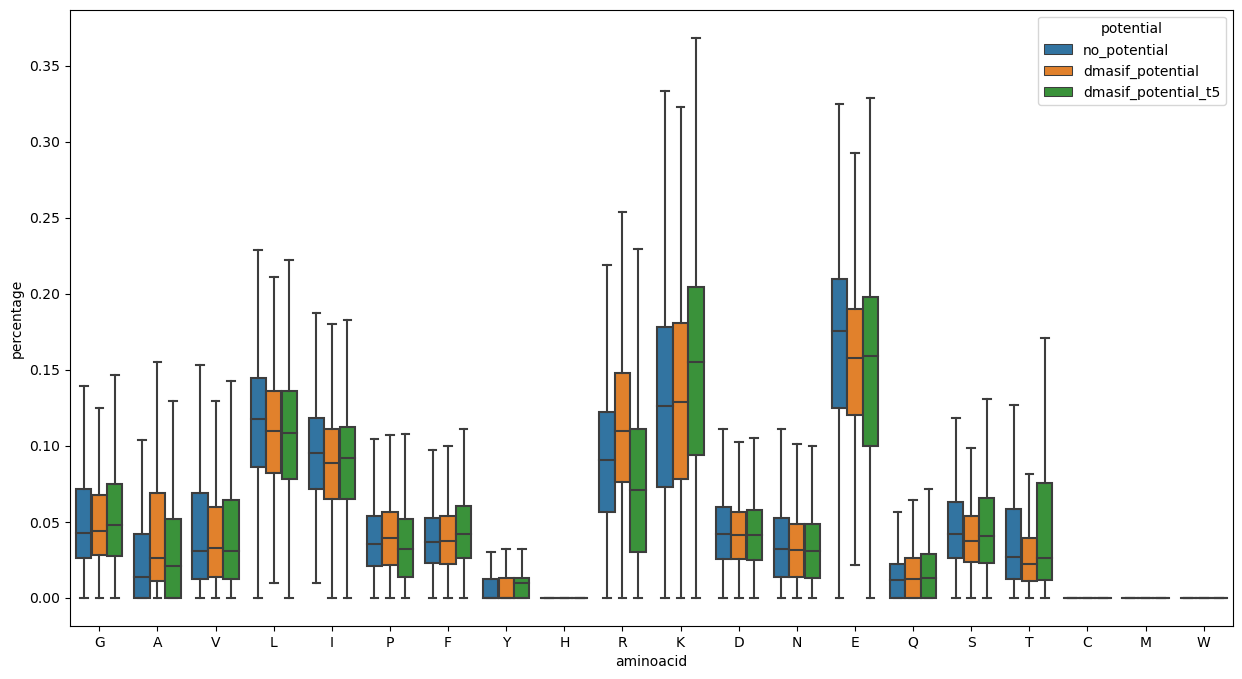

In [88]:
plt.figure(figsize=(15,8))

sns.boxplot(data=pd.melt(arr, id_vars=['potential', 'protein', 'length']), 
            x='variable', y='value', hue='potential', showfliers=False)
plt.xlabel('aminoacid')
plt.ylabel('percentage') 
plt.show()

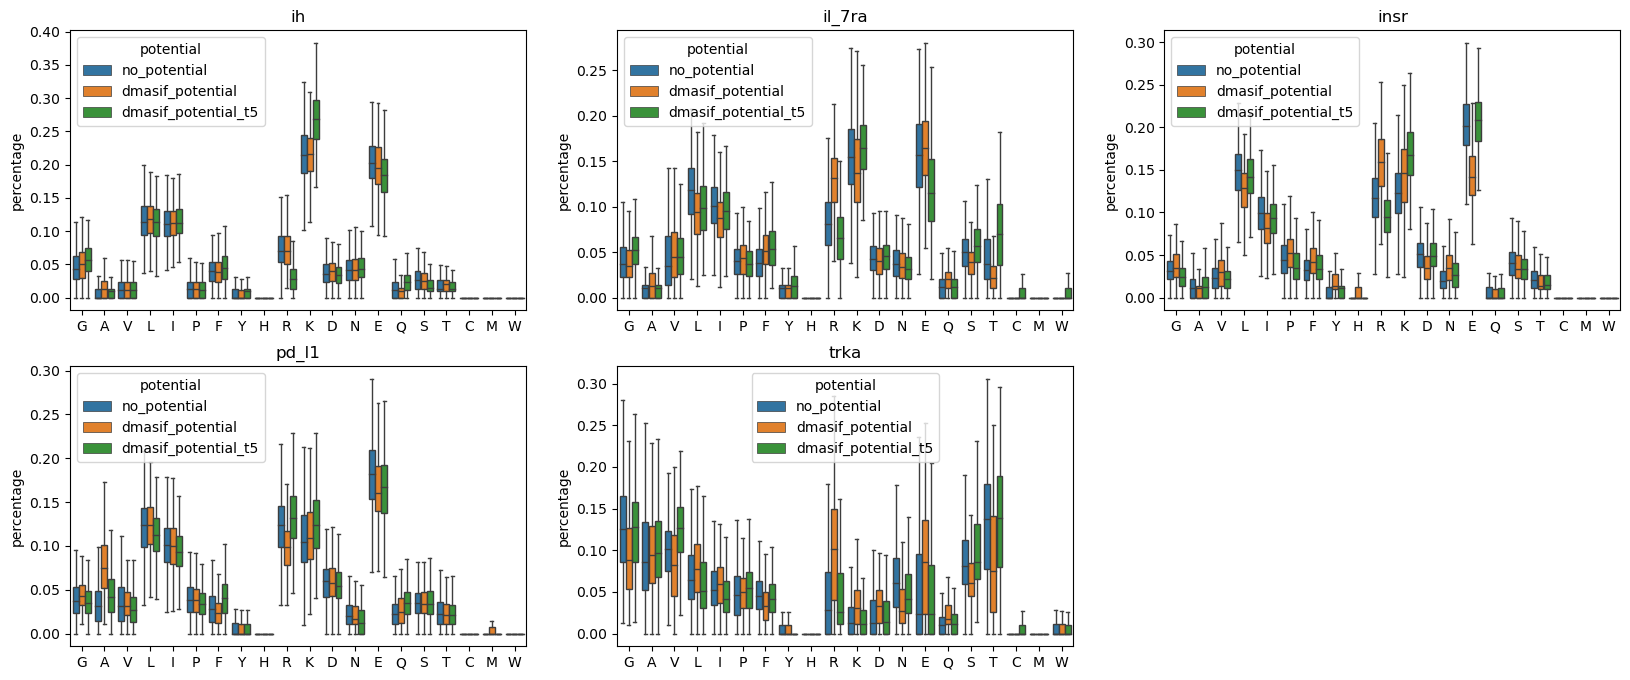

In [89]:

plt.figure(figsize=(20,8))
proteins=seq_df.protein.unique()
proteins.sort()
for i, prot in enumerate(proteins):
    plt.subplot(2,3,i+1)
    plt.title(prot)
    sns.boxplot(data=pd.melt(arr[arr.protein==prot], id_vars=['potential', 'protein', 'length']), 
            x='variable', y='value', hue='potential', showfliers=False, linewidth=1)
    plt.ylabel('percentage') 
    plt.xlabel('')
plt.show()

### Distiribution of interface aminoacids

In [96]:
import warnings
from Bio.PDB.PDBParser import PDBParser 
from Bio.PDB.Polypeptide import three_to_one
parser=PDBParser()

warnings.simplefilter("ignore")
threshold=3
seq_df['interface_residues']=None
for i in tqdm.tqdm(range(len(seq_df))):
    structure=parser.get_structure('str',f'outputs/relaxed/{seq_df.iloc[i].potential}/{seq_df.iloc[i]["name"]}.pdb')
    chain_a=[x for x in structure[0]['A'].get_atoms() if x.element!='H']
    chain_a=np.array([x.get_coord() for x in chain_a])
    interface=[]
    chain_b=[x for x in structure[0]['B'].get_atoms() if x.element!='H']
    chain_b_resi=np.array([(three_to_one(x.get_parent().get_resname()),x.get_parent().get_id()[1]) for x in chain_b])
    chain_b=np.array([x.get_coord() for x in chain_b])
    interface=((chain_b[:,None,:]-chain_a[None,:,:])**2).sum(-1).min(-1)<=threshold**2
    interface=chain_b_resi[interface]  
    seq_df['interface_residues'].iloc[i]=[x[0] for x in np.unique(interface, axis=0)]
seq_df


100%|██████████| 7500/7500 [14:08<00:00,  8.84it/s]  


,name,seq,potential,protein,interface_residues
0,pd_l1_000499,"(N, T, K, K, S, K, I, F, E, E, I, R, N, I, K, ...",no_potential,pd_l1,"[E, K, R]"
1,trka_000399,"(S, P, T, A, R, I, T, V, R, N, A, N, G, N, V, ...",no_potential,trka,[]
2,insr_000017,"(N, V, E, S, L, K, S, E, I, K, D, L, F, D, L, ...",no_potential,insr,"[D, E, K]"
3,insr_000476,"(N, D, L, L, R, L, K, E, E, L, D, K, L, V, S, ...",no_potential,insr,[V]
4,insr_000804,"(G, I, P, D, A, D, I, E, R, L, R, E, F, I, E, ...",no_potential,insr,"[E, K, R]"
...,...,...,...,...,...
7495,trka_000026,"(G, S, P, N, V, N, V, S, G, S, A, S, V, N, A, ...",dmasif_potential_t5,trka,"[S, S]"
7496,pd_l1_000173,"(D, V, E, R, Q, R, L, E, A, L, A, S, I, L, Q, ...",dmasif_potential_t5,pd_l1,"[D, E, Q, R, R]"
7497,insr_000136,"(S, K, A, D, E, E, L, R, K, L, K, E, L, I, Q, ...",dmasif_potential_t5,insr,"[E, E, R, R]"
7498,ih_000076,"(G, N, G, K, I, R, I, V, Y, G, P, R, G, K, F, ...",dmasif_potential_t5,ih,"[G, I, K, R, Y]"


In [109]:
alphabet='GAVLIPFYHRKDNEQSTCMW'
arr=seq_df[['potential', 'protein']]
arr['length']=seq_df.interface_residues.apply(lambda x: len(x))
for a in alphabet:
    arr[a]=seq_df.interface_residues.apply(lambda x: x.count(a))/arr.length
arr

,potential,protein,length,G,A,V,L,I,P,F,...,K,D,N,E,Q,S,T,C,M,W
0,no_potential,pd_l1,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.333333,0.000000,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0
1,no_potential,trka,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,no_potential,insr,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.333333,0.333333,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0
3,no_potential,insr,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,no_potential,insr,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.333333,0.000000,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,dmasif_potential_t5,trka,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0
7496,dmasif_potential_t5,pd_l1,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.200000,0.0,0.200000,0.2,0.0,0.0,0.0,0.0,0.0
7497,dmasif_potential_t5,insr,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0
7498,dmasif_potential_t5,ih,5,0.2,0.0,0.0,0.0,0.2,0.0,0.0,...,0.200000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


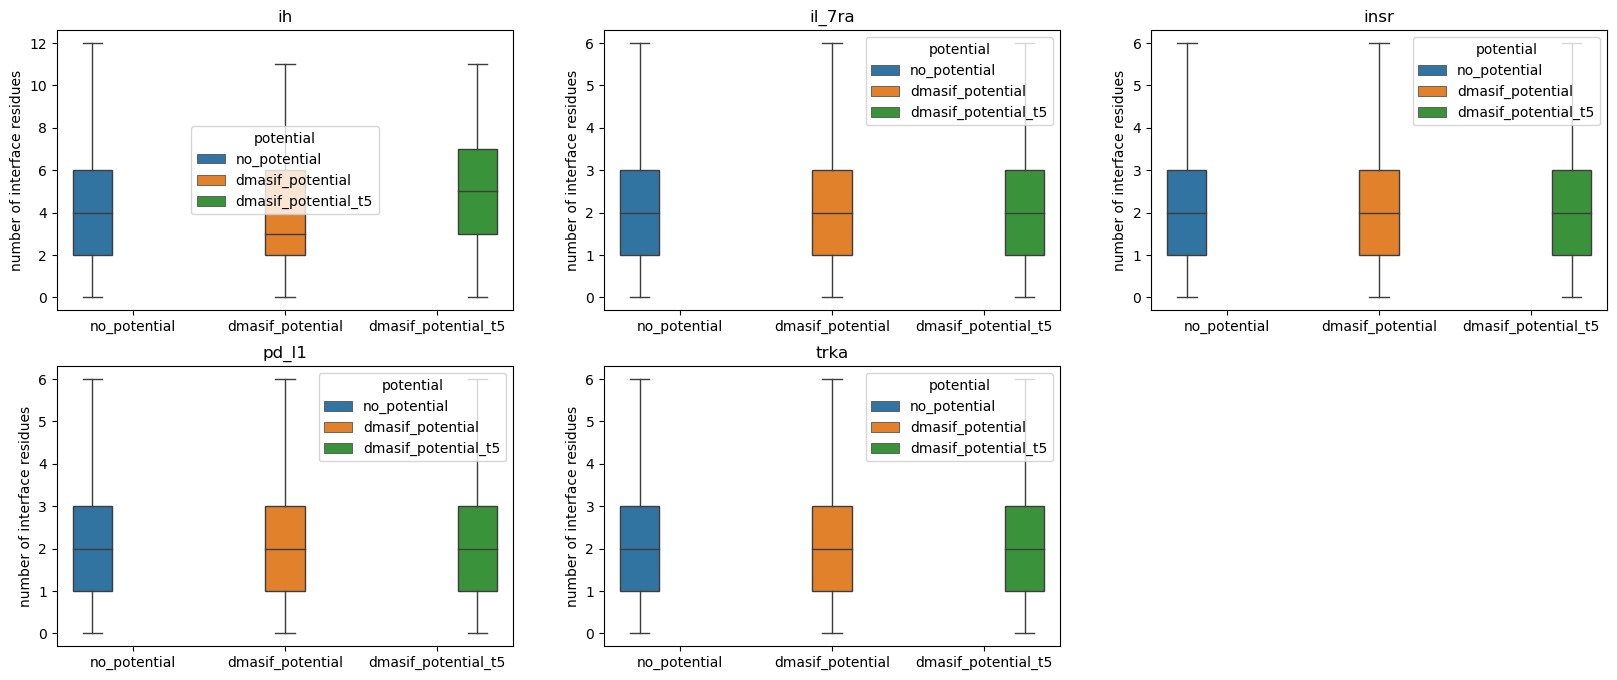

In [106]:

plt.figure(figsize=(20,8))
proteins=seq_df.protein.unique()
proteins.sort()
for i, prot in enumerate(proteins):
    plt.subplot(2,3,i+1)
    plt.title(prot)
    sns.boxplot(data=arr[arr.protein==prot], 
            x='potential', y='length', hue='potential', showfliers=False, linewidth=1)
    plt.ylabel('number of interface residues') 
    plt.xlabel('')
plt.show()

Text(0.5, 0, '')

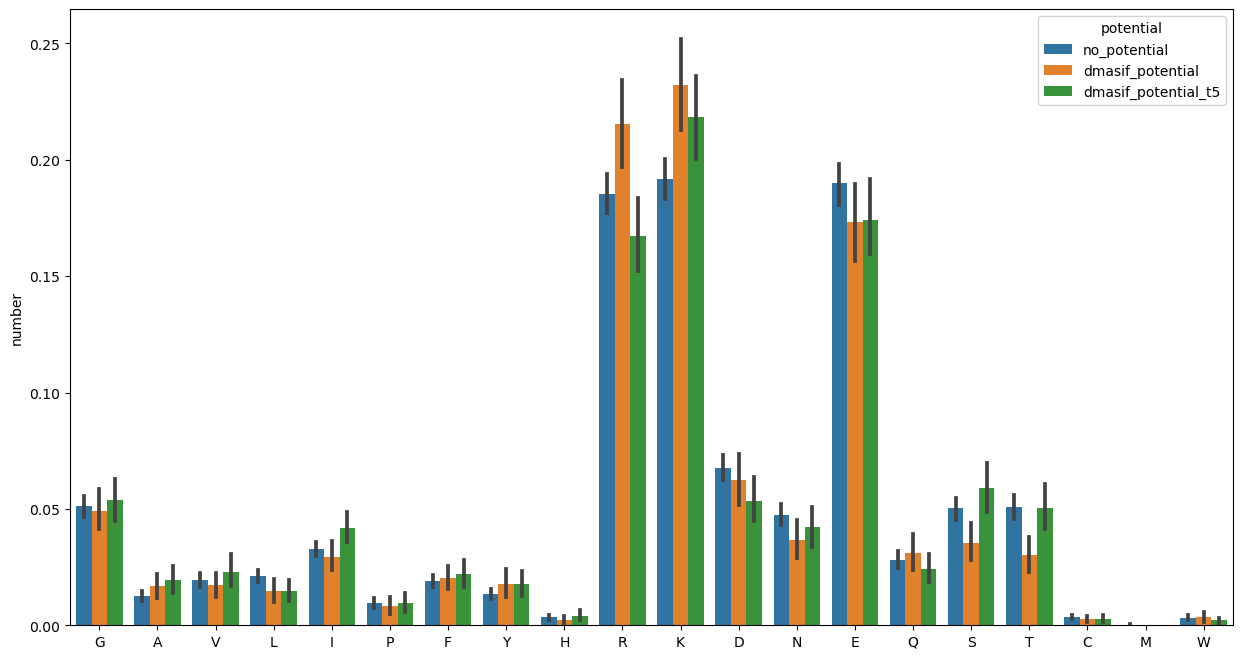

In [107]:
plt.figure(figsize=(15,8))
sns.barplot(data=pd.melt(arr, id_vars=['potential'], value_vars=[x for x in alphabet]), 
            x='variable', y='value', hue='potential')
plt.ylabel('number') 
plt.xlabel('')

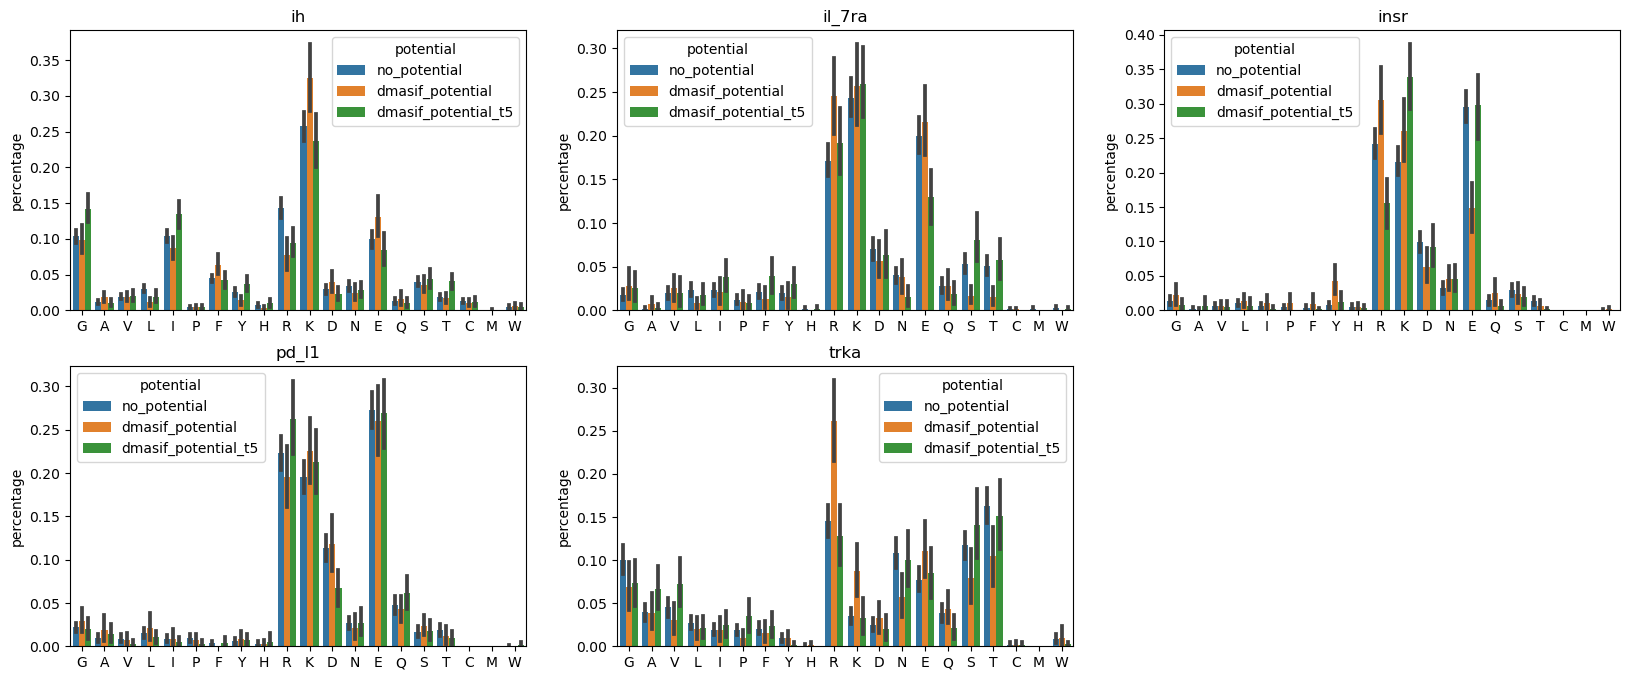

In [108]:

plt.figure(figsize=(20,8))
proteins=seq_df.protein.unique()
proteins.sort()
for i, prot in enumerate(proteins):
    plt.subplot(2,3,i+1)
    plt.title(prot)
    sns.barplot(data=pd.melt(arr[arr.protein==prot], id_vars=['potential', 'protein', 'length']), 
            x='variable', y='value', hue='potential', linewidth=1)
    plt.ylabel('percentage') 
    plt.xlabel('')
plt.show()

## Calculate ddG

In [2]:
#import importlib
#importlib.reload(pyrosetta)

from pyrosetta import *
from pyrosetta.rosetta import *
#from pyrosetta.toolbox import *
from pyrosetta.teaching import *

init("-mute all")

scorefxnDDG=get_fa_scorefxn()
fa_sol_score=ScoreFunction()
fa_sol_score.set_weight(fa_sol, 1.0)
interface_score=ScoreFunction()
interface_score.set_weight(interface_dd_pair, 1.0)

PyRosetta-4 2022 [Rosetta PyRosetta4.Release.python310.ubuntu 2022.35+release.6079c70fa16855c06a9c2070a7085bf619df3065 2022-08-31T18:05:32] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


In [3]:
from multiprocessing import Pool, cpu_count

def score(fs):
    testPose= Pose()
    testPose = pose_from_pdb(fs)
    ddg=scorefxnDDG(testPose)
    solv=fa_sol_score(testPose)
    interface=interface_score(testPose)
    clear_output()
    return ddg, solv, interface

print(cpu_count())


8


In [4]:
arr=[]
for potential in ['no_potential','dmasif_potential','dmasif_potential_t5']:
    for file in tqdm.tqdm(os.listdir(f'outputs/relaxed/{potential}')):
        if file[-3:]!='pdb':
            continue
        arr.append([f'outputs/relaxed/{potential}/{file}', 
                    file.split('.')[0],'_'.join(file.split('_')[:-1]),potential])
        
        
str_df=pd.DataFrame(columns=['path', 'name','protein','potential'], 
                    data=arr)

with Pool(cpu_count()-4) as p:
    scores=list(tqdm.tqdm(p.imap(score, str_df.path), total=len(str_df.path)))

str_df[['ddg','solv','interface']]=scores
str_df.drop('path', axis=1)
str_df

100%|██████████| 1250/1250 [00:00<00:00, 545394.78it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'outputs/relaxed/dmasif_potential_t5'

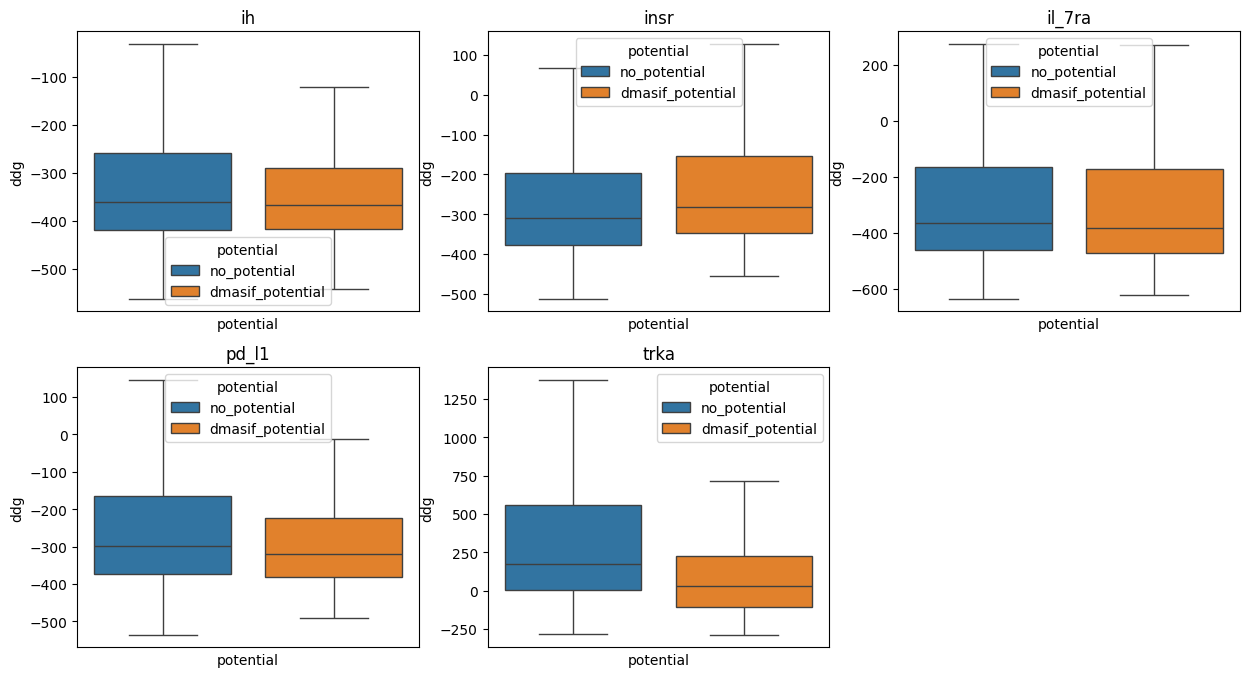

In [15]:
plt.figure(figsize=(15,8))
for i, prot in enumerate(str_df.protein.unique()):
    plt.subplot(2,3,i+1)
    plt.title(prot)
    #sns.scatterplot(str_df[str_df.protein==prot].groupby('potential').mean().iloc[:,1:].T, s=100, alpha=.7)
    sns.boxplot(x="potential", y="ddg", hue="potential",
                data=str_df[str_df.protein==prot], legend='full', showfliers=False)
    plt.xticks([])


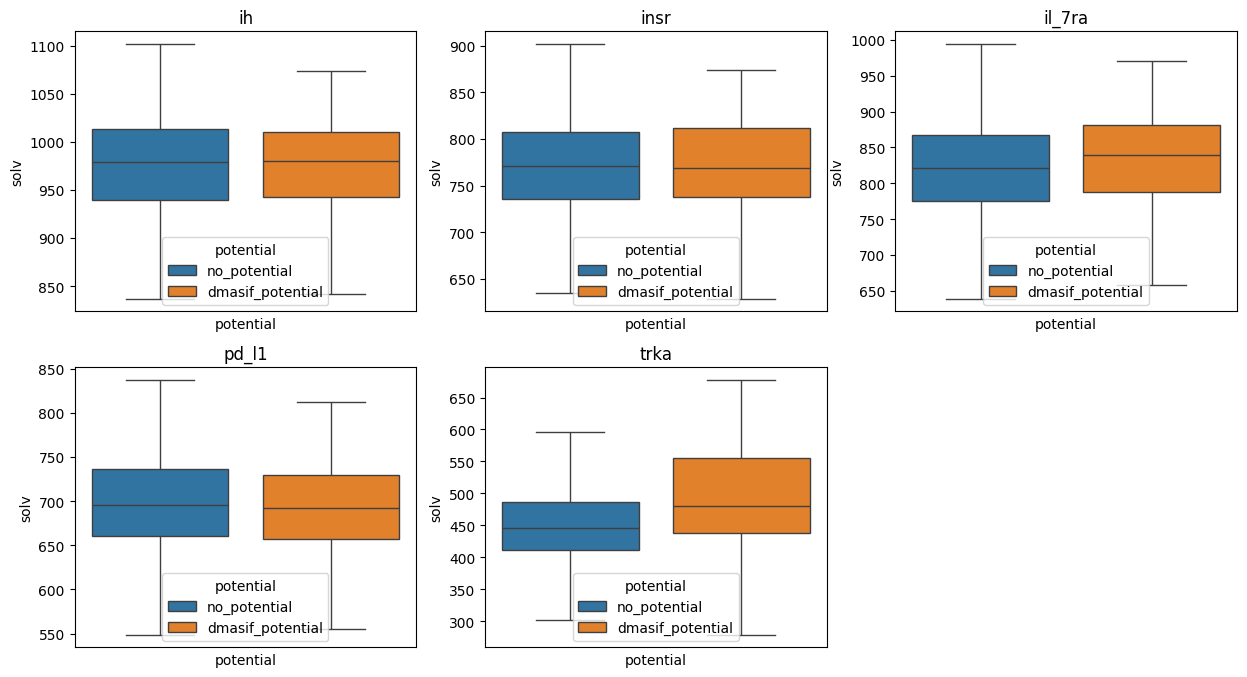

In [12]:
plt.figure(figsize=(15,8))
for i, prot in enumerate(str_df.protein.unique()):
    plt.subplot(2,3,i+1)
    plt.title(prot)
    #sns.scatterplot(str_df[str_df.protein==prot].groupby('potential').mean().iloc[:,1:].T, s=100, alpha=.7)
    sns.boxplot(x="potential", y="solv", hue="potential",
                data=str_df[str_df.protein==prot], legend='full', showfliers=False)
    plt.xticks([])

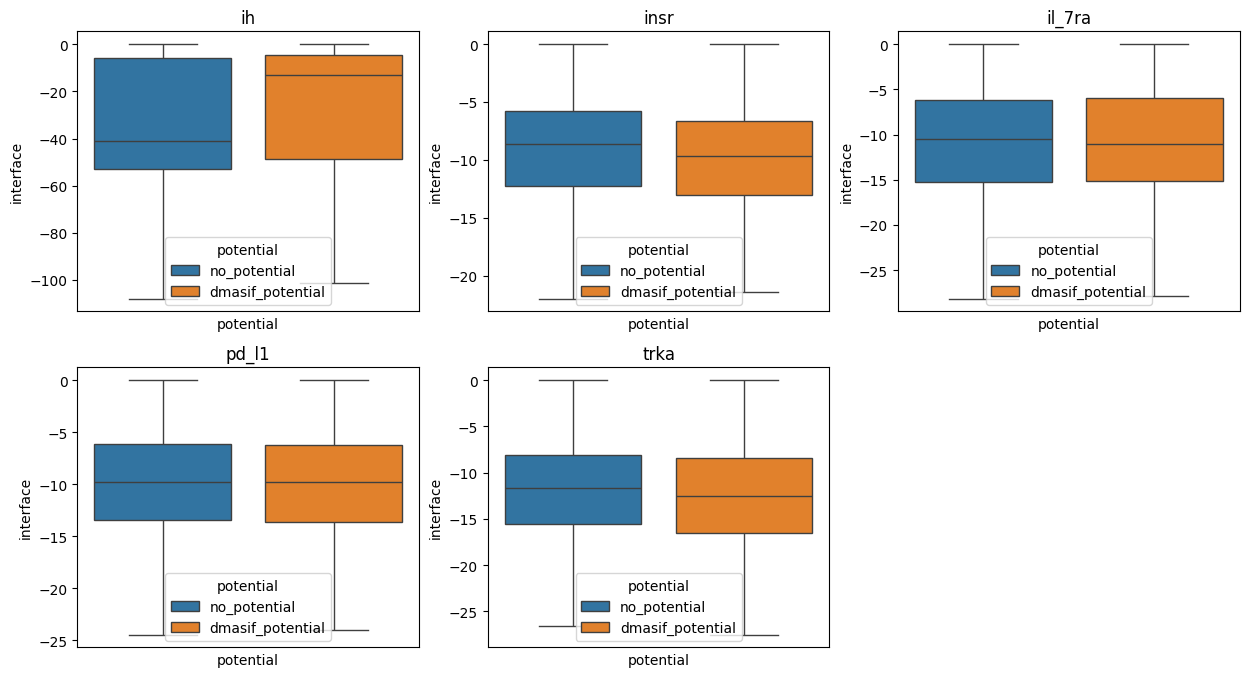

In [13]:
plt.figure(figsize=(15,8))
for i, prot in enumerate(str_df.protein.unique()):
    plt.subplot(2,3,i+1)
    plt.title(prot)
    #sns.scatterplot(str_df[str_df.protein==prot].groupby('potential').mean().iloc[:,1:].T, s=100, alpha=.7)
    sns.boxplot(x="potential", y="interface", hue="potential",
                data=str_df[str_df.protein==prot], legend='full', showfliers=False)
    plt.xticks([])

## Analyze surfaces

In [2]:
import json
surf_df=[]
for potential in ['no_potential','dmasif_potential']:
    try:
        with open(f'outputs/dmasif_output/{potential}/meta.json','r') as f:
            info=json.load(f)
    except FileNotFoundError:
        continue

    surf_df.append(pd.DataFrame.from_dict(info))
    surf_df[-1]['potential']=potential

surf_df=pd.concat(surf_df)

surf_df['PDB IDs']=surf_df['PDB IDs'].apply(lambda x: x[0])
surf_df['protein']=surf_df['PDB IDs'].apply(lambda x: '_'.join(x.split('_')[:-1]))
surf_df

,surf_time,conv_time,memory_usage,R_values/input,R_values/conv,binary_loss,complementary_loss,loss,binary_AUROC,complementary_AUROC,PDB IDs,potential,protein
0,0,0.063101,3238080512,3.079485,2.457748,0.625966,0.508607,1.134573,0.728444,0.904348,ih_000000.pdb B A,no_potential,ih
1,0,0.051958,3238080512,3.025110,2.356623,1.721532,1.226449,2.947981,0.432104,0.328655,ih_000001.pdb B A,no_potential,ih
2,0,0.052114,3238080512,3.105564,2.277101,1.542600,0.925918,2.468518,0.376800,0.476652,ih_000002.pdb B A,no_potential,ih
3,0,0.060310,3238080512,2.929820,2.599498,0.785468,0.592266,1.377734,0.601537,0.815037,ih_000003.pdb B A,no_potential,ih
4,0,0.052132,3238080512,3.043087,2.483006,0.369290,0.552588,0.921878,0.913101,0.844986,ih_000004.pdb B A,no_potential,ih
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,0,0.042293,996388864,3.173199,2.601536,0.514759,0.519381,1.034140,0.856228,0.910627,trka_000245.pdb B A,dmasif_potential,trka
1246,0,0.042912,996388864,3.362521,2.484602,0.977134,0.983118,1.960252,0.457145,0.422482,trka_000246.pdb B A,dmasif_potential,trka
1247,0,0.042847,996388864,3.445129,2.658269,0.600393,0.730853,1.331246,0.806464,0.658050,trka_000247.pdb B A,dmasif_potential,trka
1248,0,0.043108,996388864,3.390450,2.565706,1.233025,1.248834,2.481858,0.410652,0.239429,trka_000248.pdb B A,dmasif_potential,trka


([], [])

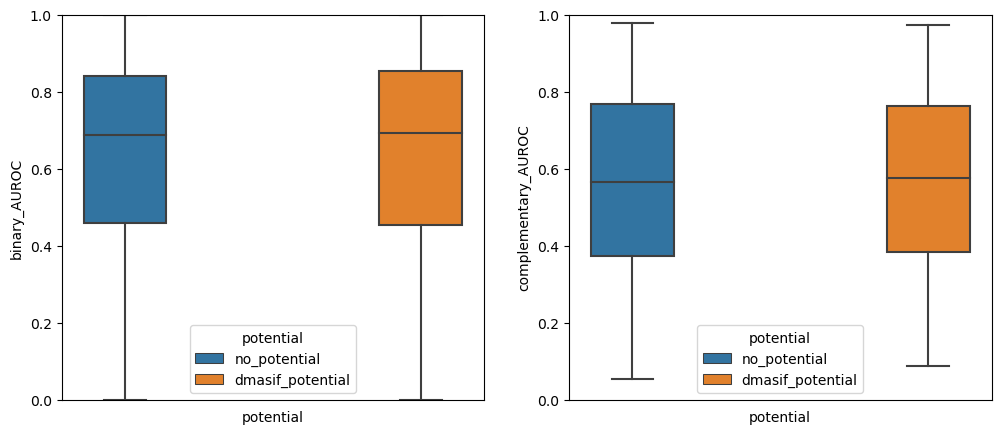

In [3]:
plt.figure(figsize=(12,5))
plt.subplot(121)
sns.boxplot(x="potential", y="binary_AUROC", hue="potential",
                data=surf_df)
plt.ylim([0,1])
plt.xticks([])
plt.subplot(122)
sns.boxplot(x="potential", y="complementary_AUROC", hue="potential",
                data=surf_df)
plt.ylim([0,1])
plt.xticks([])

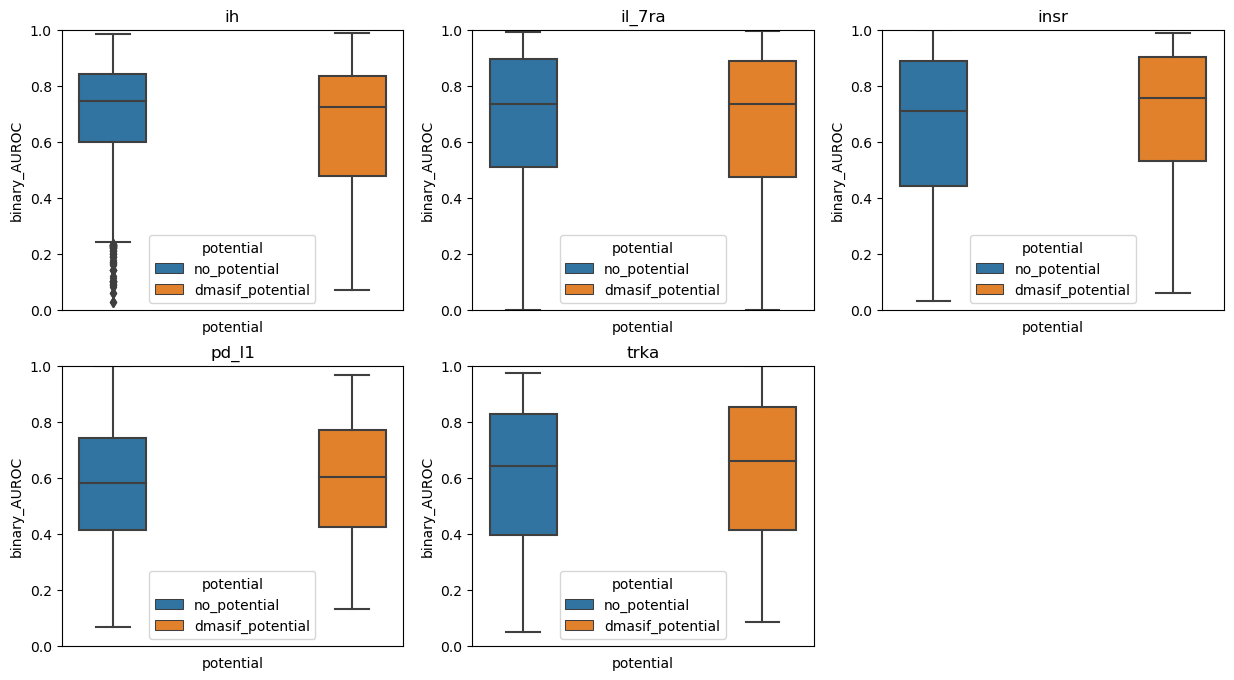

In [4]:
plt.figure(figsize=(15,8))
for i, prot in enumerate(surf_df.protein.unique()):
    plt.subplot(2,3,i+1)
    plt.title(prot)
    #sns.scatterplot(str_df[str_df.protein==prot].groupby('potential').mean().iloc[:,1:].T, s=100, alpha=.7)
    sns.boxplot(x="potential", y="binary_AUROC", hue="potential",
                data=surf_df[surf_df.protein==prot])
    plt.ylim([0,1])
    plt.xticks([])

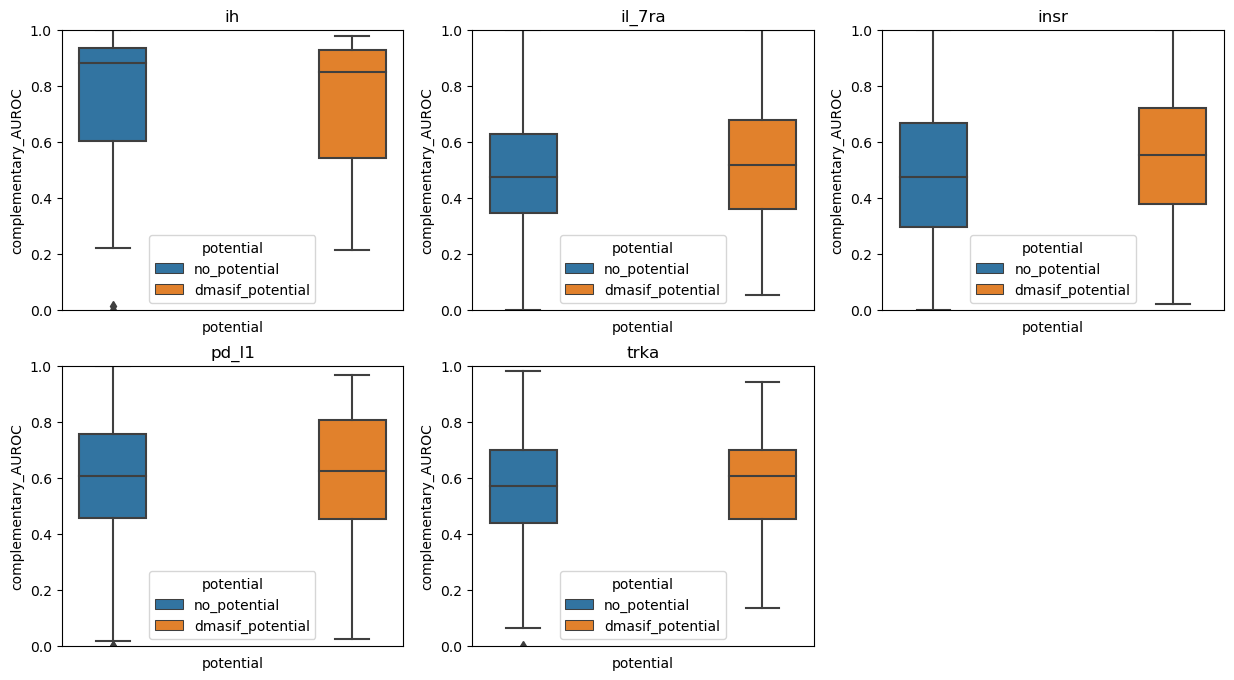

In [8]:
plt.figure(figsize=(15,8))
for i, prot in enumerate(surf_df.protein.unique()):
    plt.subplot(2,3,i+1)
    plt.title(prot)
    #sns.scatterplot(str_df[str_df.protein==prot].groupby('potential').mean().iloc[:,1:].T, s=100, alpha=.7)
    sns.boxplot(x="potential", y="complementary_AUROC", hue="potential",
                data=surf_df[surf_df.protein==prot])
    plt.ylim([0,1])
    plt.xticks([])